In [1]:
# file: levitated_nanoparticle_microgravity.py
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# ---------- Particle & trap ----------
m     = 1e-18            # kg (~100 nm silica)
omega = 2*np.pi*2e3      # trap freq 2 kHz (we can go shallower in microgravity)
Q     = 1e7              # quality factor (ultra-high vacuum)
gamma = omega/Q
ktrap = m*omega**2

# ---------- Environment ----------
Tbath = 300.0            # K (residual gas)
kB    = 1.380_649e-23
g0    = 9.80665
g_res = 1e-6*g0          # residual microgravity acceleration
dt    = 1e-6
t_end = 2.5              # seconds: simulate cooling + release + recapture

# ---------- Feedback (parametric) ----------
# k(t) = k0 * [1 + G * cos(2*omega*t + phi)] with phase from velocity estimate
Ggain = 0.2
phase = 0.0

# ---------- Noise ----------
Dth = 2*m*gamma*kB*Tbath   # thermal force spectral density (fluctuation-dissipation)

# ---------- Buffers ----------
N = int(t_end/dt)
x  = np.zeros(N); v  = np.zeros(N)
ax = np.zeros(N)
t  = np.linspace(0, t_end, N)

# ---------- Time segments ----------
t_cool    = 1.0    # parametric cooling duration
t_release = 0.8    # free drift (trap off)
t_recap   = 0.7    # re-trap
assert abs(t_cool + t_release + t_recap - t_end) < 1e-9

# ---------- Simulate ----------
rng = np.random.default_rng(123)

for i in range(1, N):
    tt = t[i]
    # segment
    if tt <= t_cool:
        # Parametric feedback: modulate trap stiffness at ~2*omega with sign set by velocity
        # use simple v estimate for phase: drive ~ -sign(v) to cool
        v_sign = np.sign(v[i-1]) if v[i-1] != 0 else 1.0
        k_eff = ktrap*(1 + Ggain * v_sign*np.cos(2*omega*tt + phase))
    elif tt <= t_cool + t_release:
        k_eff = 0.0  # trap off: free drift (microgravity)
    else:
        k_eff = ktrap  # recapture
    
    # Langevin update: m*dv = (-gamma*m*v - kx + Fth + Fg) dt
    Fth = rng.normal(scale=np.sqrt(Dth/dt))  # white-noise force
    Fg  = m*g_res
    a   = (-gamma*v[i-1] - (k_eff/m)*x[i-1] + (Fth + Fg)/m)
    v[i] = v[i-1] + a*dt
    x[i] = x[i-1] + v[i]*dt
    ax[i]= a

# ---------- Effective temperature during cooling ----------
# Use variance before end of cooling window
mask_cool = (t > 0.2) & (t <= t_cool)
T_eff = m*np.var(v[mask_cool])/kB
print(f"Effective T during cooling segment ~ {T_eff:.2f} K (toy model)")


Effective T during cooling segment ~ 0.17 K (toy model)


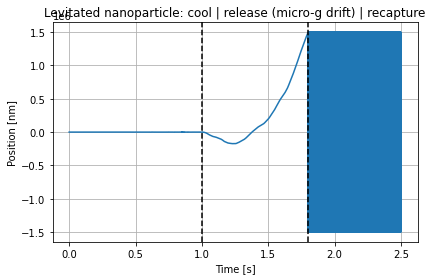

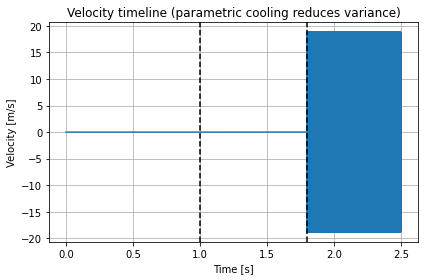

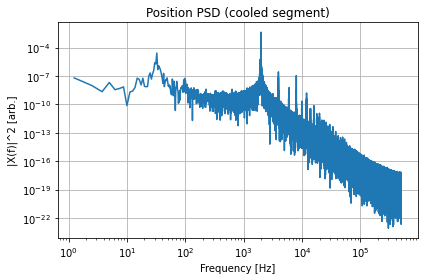

In [3]:

# ---------- Plots ----------
plt.figure(); plt.plot(t, x*1e9)
plt.axvline(t_cool, color='k', ls='--'); plt.axvline(t_cool+t_release, color='k', ls='--')
plt.xlabel('Time [s]'); plt.ylabel('Position [nm]')
plt.title('Levitated nanoparticle: cool | release (micro-g drift) | recapture')
plt.grid(); plt.tight_layout(); 

plt.figure(); plt.plot(t, v)
plt.axvline(t_cool, color='k', ls='--'); plt.axvline(t_cool+t_release, color='k', ls='--')
plt.xlabel('Time [s]'); plt.ylabel('Velocity [m/s]')
plt.title('Velocity timeline (parametric cooling reduces variance)')
plt.grid(); plt.tight_layout(); 

# Simple PSD (Welch-like)
from numpy.fft import rfft, rfftfreq
seg = x[mask_cool] - np.mean(x[mask_cool])
Xf = np.abs(rfft(seg))**2
f  = rfftfreq(seg.size, dt)
plt.figure(); plt.loglog(f[1:], Xf[1:])
plt.xlabel('Frequency [Hz]'); plt.ylabel('|X(f)|^2 [arb.]')
plt.title('Position PSD (cooled segment)')
plt.grid(); plt.tight_layout(); 
